# Example of usage Spark OCR for Text Detection using ImageTextDetectorV2

This notebook demonstrate pipeline for detect text using __ImageTextDetectorV2__ on the image.

__ImageTextDetectorV2__ can work with CPU, but prefer to use GPU for have acceptable performance.

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.11/"

In [ ]:
# install from PYPI using secret
%pip install torch
%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session

In [2]:
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path)

spark

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.11.0rc1



# Read image and display it

In [3]:
import pkg_resources
import pyspark.sql.functions as f
from pyspark.ml import PipelineModel
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/text_detection/020_Yas_patella1.jpg
    Resolution: 72 dpi
    Width: 1512 px
    Height: 2016 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


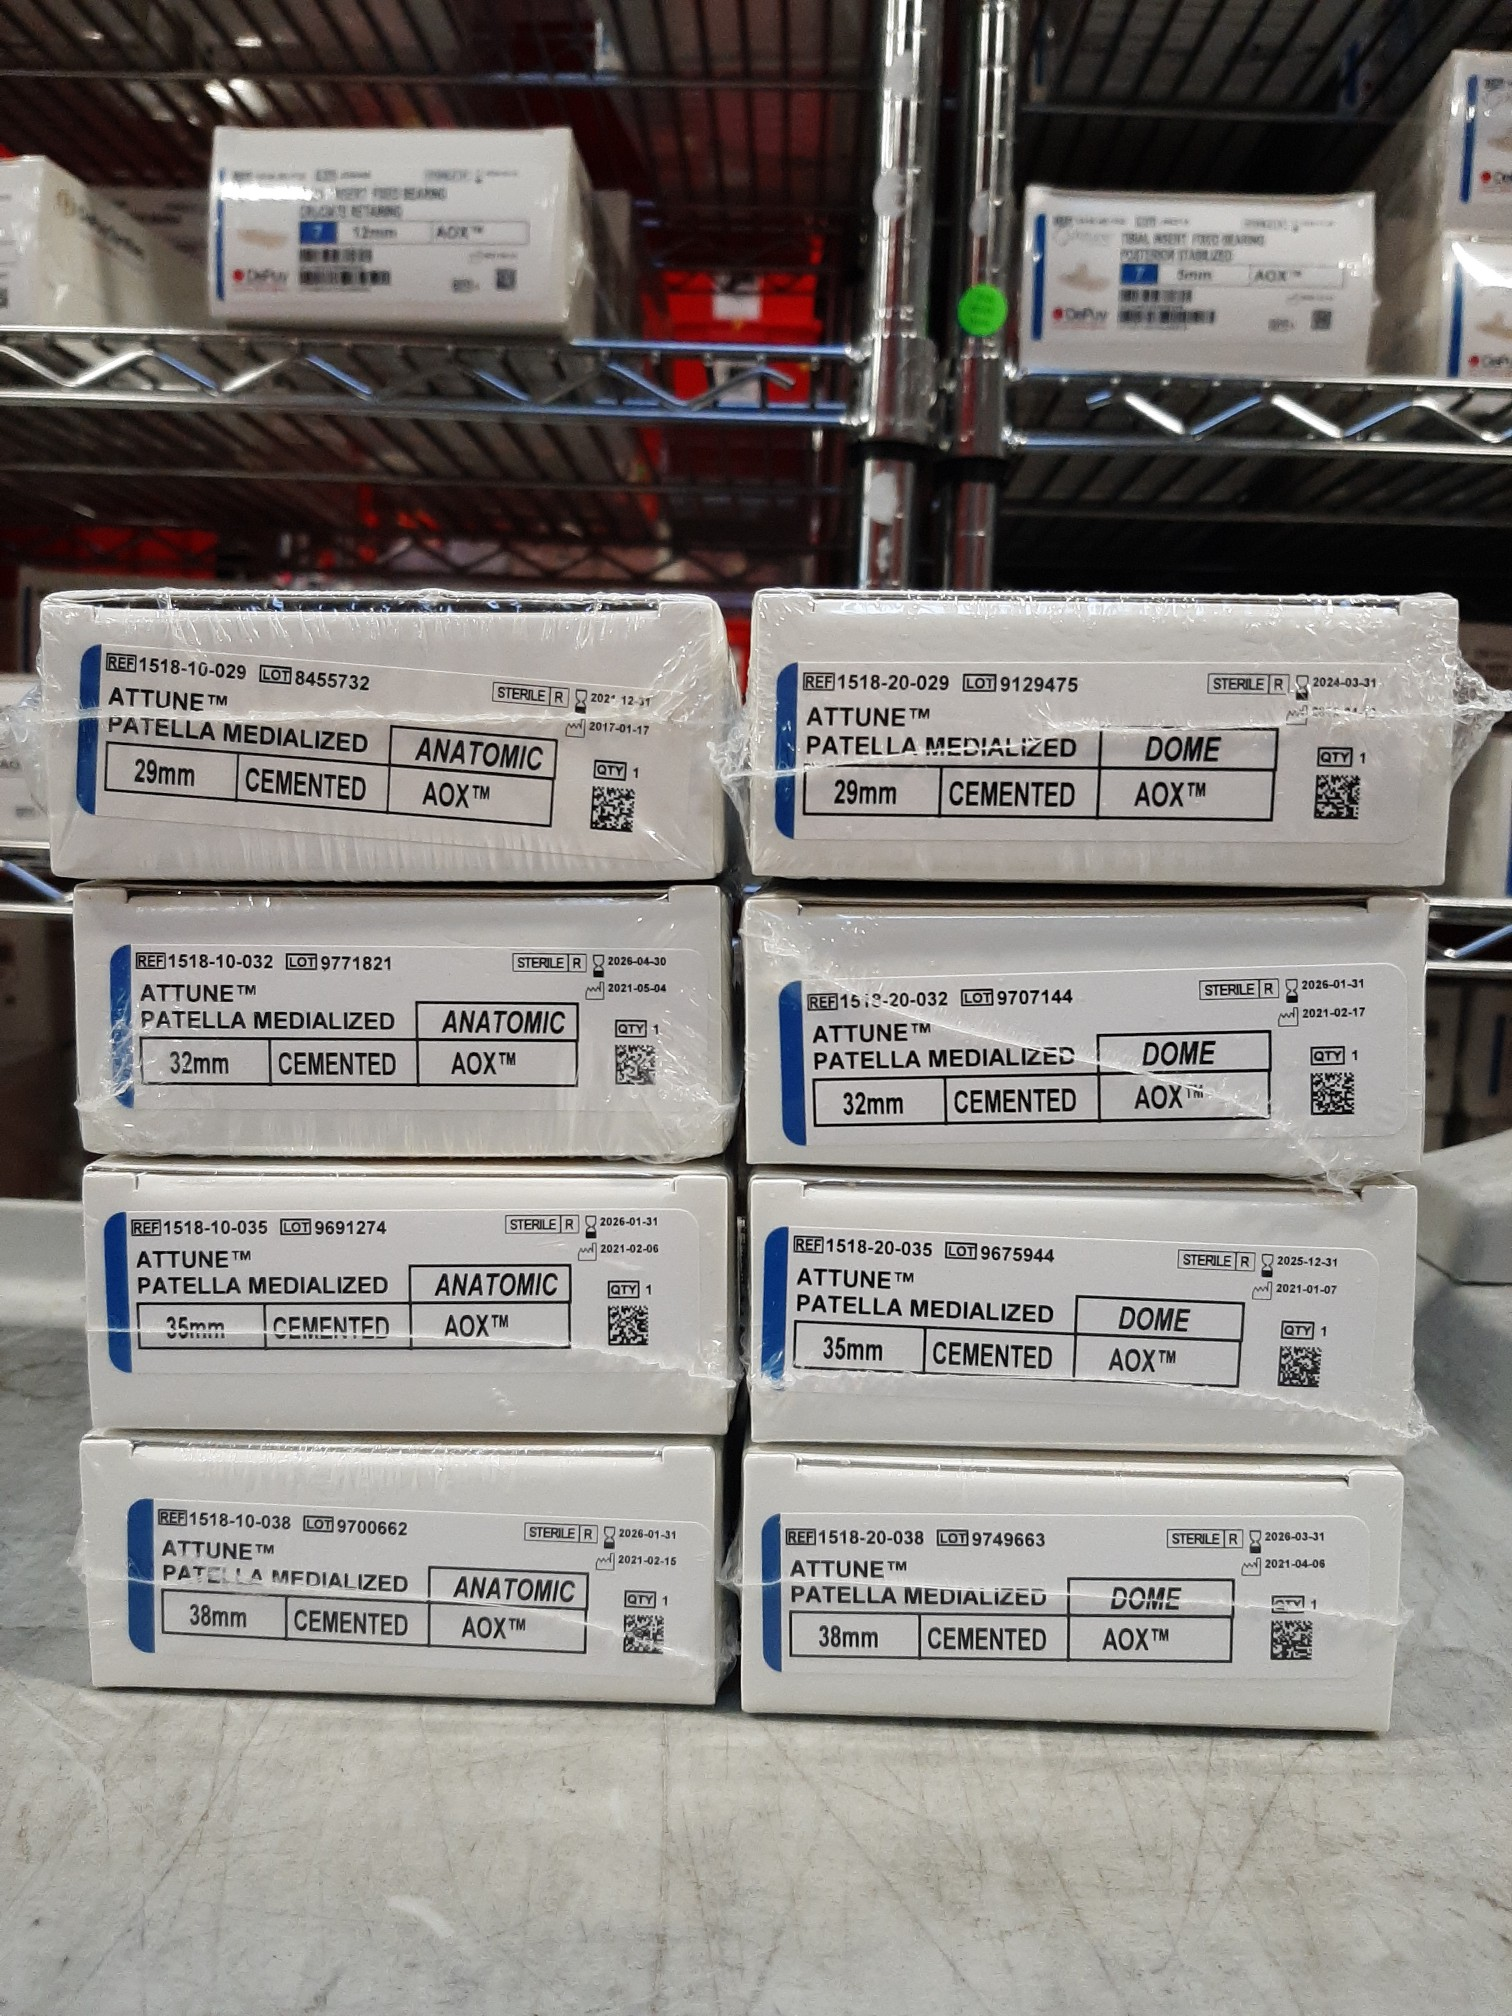


    Image #1:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


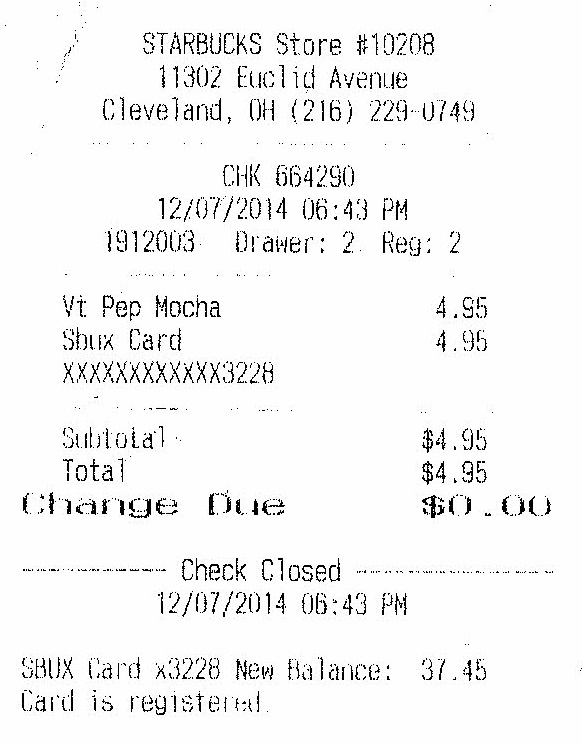

In [14]:
imagePath1 = pkg_resources.resource_filename('sparkocr', 'resources/ocr/text_detection/020_Yas_patella1.jpg')
imagePath2 = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_df = spark.read.format("binaryFile").load([imagePath1, imagePath2])

display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

# Define OCR Pipeline for detect and recognize text 

In [27]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

# Run pipeline and show results


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/text_detection/020_Yas_patella1.jpg
    Resolution: 0 dpi
    Width: 1512 px
    Height: 2016 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


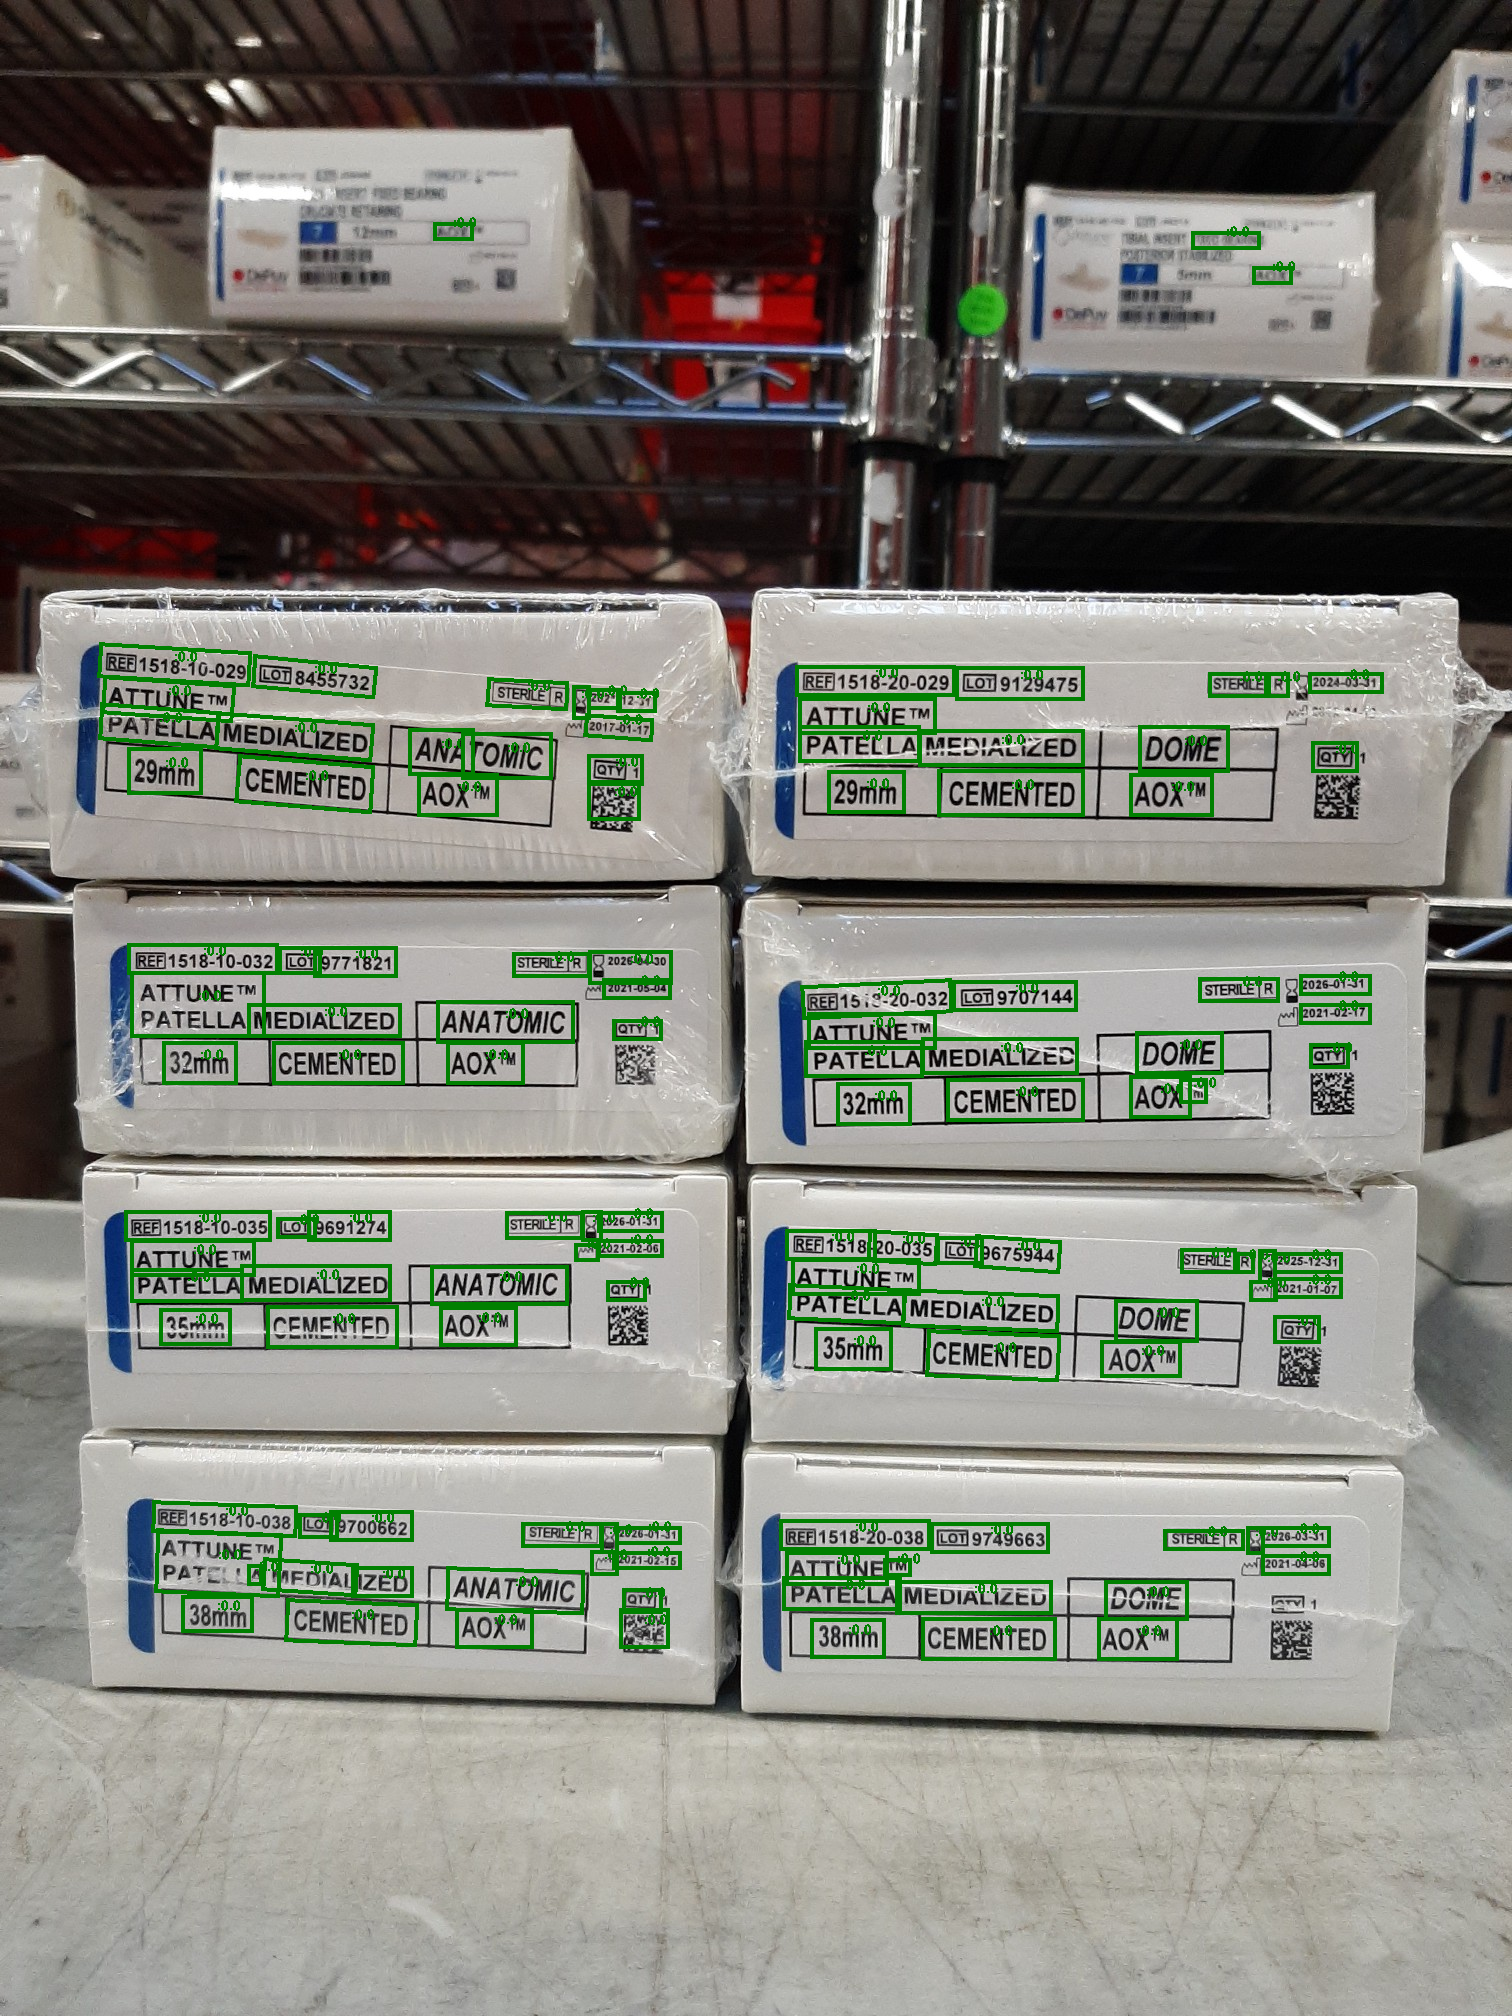


    Image #1:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


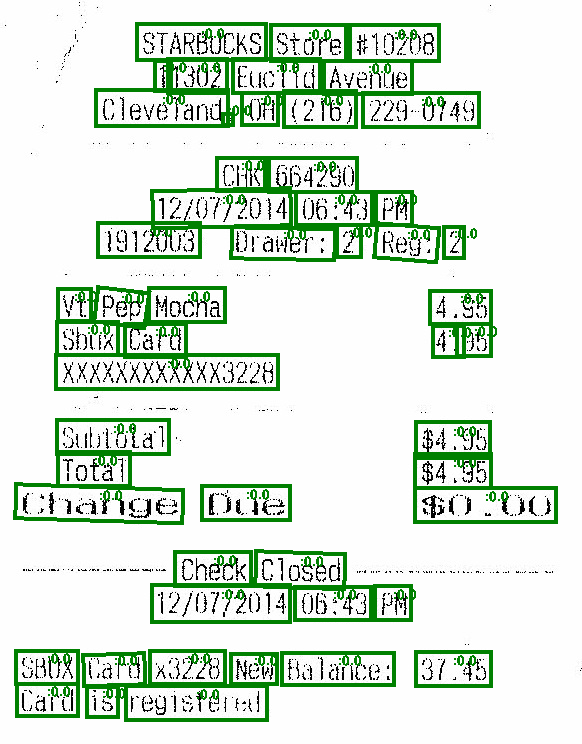

In [28]:
result = pipeline.transform(image_df)
display_images(result, "image_with_regions")